# Andromeda in Jupyter

### Interactive Inverse Dimension Reduction 

This explorable notebook demonstrates interactive dimension reduction (DR) for exploratory analysis of high-dimensional data.
It allows users to select between Multi-Dimensional Scaling (MDS), Principal Component Analysis (PCA), and t-Distributed Stochastic Neighbor Embedding (t-SNE) algorithms for the dimensionality reduction, with a weighted distance metric. It enables both forward and inverse DR interaction, to support exploration of the space of possible projections.

**MDS** projects high-dimensional data to a 2D scatterplot. A **weighted distance function** with user-specified weights on each dimension enables alternative projections that emphasize different dimensions. An **Inverse-DR** algorithm learns new distance function weights based on user placement of data points in the projection.

This notebook helps people learn about differing interpretations of similarity, based on weighted distance functions. It also demonstrates some challenges of integrating visual analytics and data science tools, by using Jupyter as a medium for Visual Analytics tool development and dissemination.

### Instructions:

1. Run All
1. Proceed to the [interactive plots](#Interactive-Visualization) near the bottom
1. There are three kinds of interactions:
    1. Select points in the DR plot and click Details to see data values.
    1. **Parametric interaction:** Adjust the [weight sliders](#Weight-Sliders) and click Apply to alter the projection plot.
    1. **Projection interaction:** Drag points in the [projection plot](#Dimension-Reduction-Plot), then click Learn to see [learned weights](#Inverse-Dimension-Reduction), and click Copy button to see the updated projection plot.
1. Be patient, its interactive matplotlib in python and Jupyter!

### Credits:

Authors: Han Liu and [Chris North](https://infovis.cs.vt.edu), Sanghani Center for AI and Analytics, Dept of Computer Science, Virginia Tech.

Based on [Andromeda](https://infovis.cs.vt.edu/andromeda): *Self JZ, Dowling M, Wenskovitch J, Crandell I, Wang M, House L, Leman S, North C. [Observation-Level and Parametric Interaction for High-Dimensional Data Analysis](https://infovis.cs.vt.edu/sites/default/files/observation-level-parametric_first_look_version.pdf). ACM Transactions on Interactive Intelligent Systems.  8(2), 2018.*


In [1]:
%matplotlib notebook
# interactive notebook format is required for the interactive plot

import numpy as np
import pandas as pd
import math
import random
import os
import re
import cv2
from skimage.transform import resize
import csv
from functools import partial
from tqdm import tqdm
#from zipfile import ZipFile

from os import listdir
from os.path import isfile, join
from math import isnan

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import sklearn.metrics.pairwise
from sklearn.metrics import silhouette_score

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.widgets import Slider, Button

import ipywidgets as widgets
from ipywidgets import interact, Layout, Button, GridBox, ButtonStyle
from IPython.display import display, clear_output, Image

import ipyplot

import torch
import io
import urllib.request

Installing widgets and widgetsnbextension: https://ipywidgets.readthedocs.io/en/latest/user_install.html 

# Load and Pre-process Data

Change the **filename** to load a dataset.  CSV data file is expected to have a first column 'Name' that is used as the index, and header row of column names.  Only numeric columns are used for projection.  Numeric columns can be normalized by [z-score](https://en.wikipedia.org/wiki/Standard_score).

The current version of this jupyter notebook only contains a finite set of images that don't capture every single animal in the dataset. To add images, place the image in the 'AndromedaImages' repository and edit the 'Animal_Data_Andromeda-Image.csv' file to have the relative path of the image. It should look like this:

| Name         | Image                               |
|--------------|-------------------------------------|
| Grizzly Bear | ./AndromedaImages/grizzly-bear.png  |
| Killer Whale | ./AndromedaImages/killer-whale.jpg  |

In [2]:
w = widgets.IntSlider()
uploader = widgets.FileUpload(
    accept='*.csv',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

display(uploader)

FileUpload(value={}, accept='*.csv', description='Upload')

In [3]:
input_file = list(uploader.value.values())[0]
content = input_file['content']
content = io.StringIO(content.decode('utf-8'))
df = pd.read_csv(content)
df.head()

,Name,Image,Water,Toughskin,Timid,Tail,Strength,Stalker,Spots,Speed,Smart,Size,Quadrupedal,Paws,Pads,Oldworld,Nocturnal,Newworld
0,Grizzly Bear,https://inaturalist-open-data.s3.amazonaws.com...,7.64,21.82,12.50,9.38,78.48,26.05,0.00,46.97,24.00,86.69,36.77,69.60,3.75,3.95,24.32,61.54
1,Killer Whale,https://inaturalist-open-data.s3.amazonaws.com...,79.49,57.04,9.77,41.67,63.35,15.00,32.69,57.37,52.03,90.85,0.00,0.00,0.00,12.50,8.75,16.25
2,Beaver,https://inaturalist-open-data.s3.amazonaws.com...,65.62,25.00,31.88,86.56,32.81,1.25,7.50,25.00,41.88,6.88,24.38,39.38,24.38,19.06,21.88,63.44
3,Dalmatian,https://inaturalist-open-data.s3.amazonaws.com...,1.25,7.50,31.67,53.75,34.93,8.75,100.00,61.74,53.26,39.31,77.92,69.03,7.50,29.86,2.50,63.47
4,Persian Cat,https://inaturalist-open-data.s3.amazonaws.com...,1.25,6.25,43.69,66.80,12.58,9.03,6.25,26.98,38.62,6.25,66.15,68.81,42.44,54.31,10.55,50.66


In [4]:
df

,Name,Image,Water,Toughskin,Timid,Tail,Strength,Stalker,Spots,Speed,Smart,Size,Quadrupedal,Paws,Pads,Oldworld,Nocturnal,Newworld
0,Grizzly Bear,https://inaturalist-open-data.s3.amazonaws.com...,7.64,21.82,12.50,9.38,78.48,26.05,0.00,46.97,24.00,86.69,36.77,69.60,3.75,3.95,24.32,61.54
1,Killer Whale,https://inaturalist-open-data.s3.amazonaws.com...,79.49,57.04,9.77,41.67,63.35,15.00,32.69,57.37,52.03,90.85,0.00,0.00,0.00,12.50,8.75,16.25
2,Beaver,https://inaturalist-open-data.s3.amazonaws.com...,65.62,25.00,31.88,86.56,32.81,1.25,7.50,25.00,41.88,6.88,24.38,39.38,24.38,19.06,21.88,63.44
3,Dalmatian,https://inaturalist-open-data.s3.amazonaws.com...,1.25,7.50,31.67,53.75,34.93,8.75,100.00,61.74,53.26,39.31,77.92,69.03,7.50,29.86,2.50,63.47
4,Persian Cat,https://inaturalist-open-data.s3.amazonaws.com...,1.25,6.25,43.69,66.80,12.58,9.03,6.25,26.98,38.62,6.25,66.15,68.81,42.44,54.31,10.55,50.66
5,Horse,https://inaturalist-open-data.s3.amazonaws.com...,2.22,42.45,35.39,70.42,69.13,0.00,15.80,81.68,37.28,71.50,70.35,0.00,3.70,50.07,1.11,62.29
6,German Shepherd,https://inaturalist-open-data.s3.amazonaws.com...,3.75,18.46,10.00,72.30,62.33,21.02,11.59,57.02,57.53,54.88,82.93,59.80,41.94,48.92,7.50,64.49
7,Blue Whale,https://inaturalist-open-data.s3.amazonaws.com...,76.61,45.17,44.58,26.42,55.26,0.00,23.75,21.42,39.06,86.46,0.00,0.00,0.00,30.21,6.25,33.96
8,Siamese Cat,https://inaturalist-open-data.s3.amazonaws.com...,2.22,5.00,28.82,59.15,8.96,51.61,6.94,43.24,52.90,2.22,80.44,64.22,31.44,58.20,29.16,64.25


In [5]:
df.set_index('Name', inplace=True)
df.sort_index(inplace=True)

In [6]:
df

,Image,Water,Toughskin,Timid,Tail,Strength,Stalker,Spots,Speed,Smart,Size,Quadrupedal,Paws,Pads,Oldworld,Nocturnal,Newworld
Name,,,,,,,,,,,,,,,,,
Beaver,https://inaturalist-open-data.s3.amazonaws.com...,65.62,25.00,31.88,86.56,32.81,1.25,7.50,25.00,41.88,6.88,24.38,39.38,24.38,19.06,21.88,63.44
Blue Whale,https://inaturalist-open-data.s3.amazonaws.com...,76.61,45.17,44.58,26.42,55.26,0.00,23.75,21.42,39.06,86.46,0.00,0.00,0.00,30.21,6.25,33.96
Dalmatian,https://inaturalist-open-data.s3.amazonaws.com...,1.25,7.50,31.67,53.75,34.93,8.75,100.00,61.74,53.26,39.31,77.92,69.03,7.50,29.86,2.50,63.47
German Shepherd,https://inaturalist-open-data.s3.amazonaws.com...,3.75,18.46,10.00,72.30,62.33,21.02,11.59,57.02,57.53,54.88,82.93,59.80,41.94,48.92,7.50,64.49
Grizzly Bear,https://inaturalist-open-data.s3.amazonaws.com...,7.64,21.82,12.50,9.38,78.48,26.05,0.00,46.97,24.00,86.69,36.77,69.60,3.75,3.95,24.32,61.54
Horse,https://inaturalist-open-data.s3.amazonaws.com...,2.22,42.45,35.39,70.42,69.13,0.00,15.80,81.68,37.28,71.50,70.35,0.00,3.70,50.07,1.11,62.29
Killer Whale,https://inaturalist-open-data.s3.amazonaws.com...,79.49,57.04,9.77,41.67,63.35,15.00,32.69,57.37,52.03,90.85,0.00,0.00,0.00,12.50,8.75,16.25
Persian Cat,https://inaturalist-open-data.s3.amazonaws.com...,1.25,6.25,43.69,66.80,12.58,9.03,6.25,26.98,38.62,6.25,66.15,68.81,42.44,54.31,10.55,50.66
Siamese Cat,https://inaturalist-open-data.s3.amazonaws.com...,2.22,5.00,28.82,59.15,8.96,51.61,6.94,43.24,52.90,2.22,80.44,64.22,31.44,58.20,29.16,64.25


In [7]:
label_names = df.index.tolist()
label_names

['Beaver',
 'Blue Whale',
 'Dalmatian',
 'German Shepherd',
 'Grizzly Bear',
 'Horse',
 'Killer Whale',
 'Persian Cat',
 'Siamese Cat']

In [8]:
image_paths = {}
for name in label_names:
    image_paths[name] = df['Image'][name]

In [10]:
df = df.loc[:, df.columns != 'Image']
# split data into two groups, we are focused on using numerical data only
df_numeric = df.select_dtypes(include='number')  #'int32' or 'int64' or 'float32' or 'float64'
df_category = df.select_dtypes(exclude='number') #'object'

In [11]:
normalized_df = (df_numeric - df_numeric.mean()) / df_numeric.std()

In [12]:
def distance_matrix_HD(dataHDw):  
    """
    Compute the distance matrix for the weighted high-dimensional data using L1 distance function.
    Input HD data should already be weighted.
    
    @parameters:
        dataHDw[pd.df or np.array]: weighted high-dimensional data
    @return[array]: distance matrix for input weighted high-dimensional data
    """
    dist_matrix = sklearn.metrics.pairwise.manhattan_distances(dataHDw)
    return dist_matrix

def distance_matrix_2D(data2D): 
    """
    Compute the distance matrix for 2D projected data using L2 distance function.
    
    @parameters: 
        data2D[pd.df or np.array]: projected 2D data
    @return[np.array]: distance matrix for 2D input data
    """
    dist_matrix = sklearn.metrics.pairwise.euclidean_distances(data2D) 
    return dist_matrix


def stress(distHD, dist2D): 
    """
    Calculate the MDS stress metric between HD and 2D distances.
    @parameters: 
        distHD[np.array]: distance matrix for high-dimensional data
        dist2D[np.array]: distance matrix for 2D data
    @return[float]: stress value
    """
    s = ((distHD-dist2D)**2).sum() / (distHD**2).sum()   # numpy, eliminate sqrt for efficiency
    return s

def compute_mds(dataHDw):  
    """
    apply MDS to high-dimensional data to get 2D data
    @parameters:
        dataHDw[pd.df or np.array]: weighted high-dimensional data
    @return[dataframe]: a dataframe of 2D data 
    """
    distHD = distance_matrix_HD(dataHDw)
    ### Adjust these parameters for performance/accuracy tradeoff
    mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed', n_init=10, max_iter=1000, random_state=3)
    # Reduction algorithm happens here:  data2D is n*2 matrix
    data2D = mds.fit_transform(distHD)
    
    ### Rotate the resulting 2D projection to make it more consistent across multiple runs.
    ### Set the 1st PC to the y axis, plot looks better to spread data vertically with horizontal text labels
    pca = sklearn.decomposition.PCA(n_components=2)
    data2D = pca.fit_transform(data2D)
    data2D = pd.DataFrame(data2D, columns=['y','x'], index=dataHDw.index)
    
    data2D.stress_value = stress(distHD, distance_matrix_2D(data2D))
    return data2D

def dimension_reduction(dataHD, wts): # dataHD, wts -> data2D (pandas)
    """
    apply weights to high-dimensional data then apply MDS to get 2D data
    @parameters:
        dataHD[pd.df or np.array]: original high-dimensional data
    @return[dataframe]: a dataframe of projected 2D data
    """
    ### Normalize the weights to sum to 1
    wts = wts/wts.sum()
    
    ### Apply weights to the HD data 
    dataHDw = dataHD * wts
    
    ### DR algorithm
    data2D = compute_mds(dataHDw)

    ### Compute row relevances as:  data dot weights
    ### High relevance means large values in upweighted dimensions
#     data2D['relevance'] = dataHDw.sum(axis=1)
    return data2D



In [13]:
min_weight, max_weight = 0.00001, 0.9999
init_weight = min_weight  # 1.0/len(normalized_df.columns) # initialize to min to make the sliders easier to use.
weights = pd.Series(init_weight, index=normalized_df.columns, name="Weight")  # the current weight list

df_2D = dimension_reduction(normalized_df, weights)   # the current projected data

In [14]:
weights.head(2)

Water        0.00001
Toughskin    0.00001
Name: Weight, dtype: float64

In [15]:
pd.DataFrame(distance_matrix_HD(normalized_df * (weights/weights.sum())), 
             columns=normalized_df.index, index=normalized_df.index).head(2)

Name,Beaver,Blue Whale,Dalmatian,German Shepherd,Grizzly Bear,Horse,Killer Whale,Persian Cat,Siamese Cat
Name,,,,,,,,,
Beaver,0.0000,0.9997,1.083309,1.091508,1.152120,1.116111,1.308289,0.813477,0.988867
Blue Whale,0.9997,0.0000,1.348597,1.478973,1.272187,0.909468,0.669218,1.267035,1.777269


In [16]:
print(df_2D.stress_value)
df_2D.head(2)

0.033982674611626566


,y,x
Name,,
Beaver,-0.121685,-0.687287
Blue Whale,0.803424,-0.473769


# Inverse Dimension-Reduction Learning Algorithm

Computes the inverse-Dimension-Reduction: given input 2D points, compute new weights.
Optimizes the [MDS stress function](https://en.wikipedia.org/wiki/Multidimensional_scaling) that compares 2D pairwise distances (||$x_i-x_j||$) to weighted HD pairwise distances ($d_{ij}$):
![Stress](https://wikimedia.org/api/rest_v1/media/math/render/svg/7989b3afc0d8795a78c1631c7e807f260d9cfe68)

Technically, we compute the inverse weighted distance function. We shortcut the optimization by eliminating MDS from the process, and assume that the user input 2D distances are actually the desired HD distances, not the 2D distances after re-projection. Thus, given the input (HD) distances, we find weights that would produce these distances in the HD space.

In [17]:
# This method is used to propose a new weight for current column in a smart fashion
def new_proposal(current, step, direction):
    return np.clip(current + direction*step*random.random(), 0.00001, 0.9999)

def inverse_DR(dataHD, data2D, curWeights=None): 
    """
    @parameters:
        dataHD[pd.df or np.array]: high-dimensional data
        data2D[pd.df or np.array]: projected 2D data
    @return[pd.Series]: new weights  
    """
    dist2D = distance_matrix_2D(data2D)  # compute 2D distances only once
    col_names = dataHD.columns
    dataHD = dataHD.to_numpy()  # use numpy for efficiency
    row, col = dataHD.shape
    
    if curWeights==None:
        curWeights = np.array([1.0/col]*col)  # default weights = 1/p
    else:
        curWeights = curWeights.to_numpy()
        curWeights = curWeights / curWeights.sum()  # Normalize weights to sum to 1
    newWeights = curWeights.copy()  # re-use this array for efficiency
    
    # Initialize state
    flag = [0]*col         # degree of success of a weight change
    direction = [1]*col  # direction to move a weight, pos or neg
    step = [1.0/col]*col   # how much to change each weight
    
    dataHDw = dataHD * curWeights   # weighted space, re-use this array for efficiency
    distHD = distance_matrix_HD(dataHDw)
    curStress = stress(distHD, dist2D)
    print('Starting stress =', curStress, 'Processing...')

    MAX = 500   # default setting of the number of iterations

    # Try to minorly adjust each weight to see if it reduces stress
    for i in range(MAX):
        for dim in range(col):            
            # Get a new weight for current column
            nw = new_proposal(curWeights[dim], step[dim], direction[dim])
            
            # Scale the weight list such that it sums to 1
            s = 1.0  + nw - curWeights[dim]   # 1.0 == curWeights.sum()
            np.true_divide(curWeights, s, out=newWeights)  # transfers to other array, while doing /
            newWeights[dim] = nw / s
            
            # Apply new weights to HD data
            np.multiply(dataHD, newWeights, out=dataHDw)  # dataHDw = dataHD * newWeights; efficiently reuses dataHDw array
            distHD = distance_matrix_HD(dataHDw)

            # Get the new stress
            newStress = stress(distHD, dist2D)
            
            # If new stress is lower, then update weights and flag this success
            if newStress < curStress:
                temp = curWeights
                curWeights = newWeights
                newWeights = temp   # reuse the old array next iteration
                curStress = newStress
                flag[dim] = flag[dim] + 1
            else:
                flag[dim] = flag[dim] - 1
                direction[dim] = -direction[dim]  # Reverse course
    
            # If recent success, then speed up the step rate
            if flag[dim] >= 5:
                step[dim] = step[dim] * 2
                flag[dim] = 0
            elif flag[dim] <= -5:
                step[dim] = step[dim] / 2
                flag[dim] = 0
                
    print('Solution stress =', curStress, 'Done.')
    return pd.Series(curWeights, index=col_names, name="Weight")


# Visualization and UI code

These functions create the GUI components.

## Sliders

In [18]:
# slider for adjusting image size
def create_size_slider(imgDisplaySize):
    """
    Create image size adjust slider
    @parameters:
        imgDisplaySize[float]: zoom image displayed size
    @return[widgets slider]: return the slize adjustment slider 
    """

    style = {'description_width': 'initial'}
    size_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=imgDisplaySize, 
                                       description='Adjust image size', style = style, 
                                   continuous_update=False, readout_format='.5f',)
    size_slider.style.handle_color = 'lightblue'
    return size_slider

# sliders for weights
def create_sliders(wts):
    # Create sliders, one for each dimension weight
    sliders = [widgets.FloatSlider(min=min_weight, max=max_weight, step=0.01, value=value, 
                                       description=label, continuous_update=False,
                                   layout=Layout(width='100%'),readout_format='.5f')
                   for (label, value) in wts.iteritems()]
    for slider in sliders:
        slider.style.handle_color = 'lightgreen'
        display(slider)
        
    return sliders

# checkboxes
def create_checkbox(size_slider, ax):
    """
    @return: create the checkbox to toggle the images and titles(image index in the dataframe)  
    """
    title_checkbox = widgets.Checkbox(False, description='Toggle Titles',indent=False,
                                      layout=Layout(width='20%', height='20px'))
    image_checkbox = widgets.Checkbox(True, description='Toggle Images',indent=False,
                                      layout=Layout(width='20%', height='20px'))
    
    def title_check_clicked(x):   
        image = image_checkbox.value
        draw_plot(ax, df_2D, size_slider.value, x, image)
    interact(title_check_clicked, x=title_checkbox)
    
    def image_clicked(x):   
        title = title_checkbox.value
        draw_plot(ax, df_2D, size_slider.value, title, x)
    interact(image_clicked, x=image_checkbox)
    return title_checkbox, image_checkbox

In [19]:
##Buttons
# apply adjusted size to display images
def create_size_slider_button(size_slider, ax): 
    """
    @parameters:
        size_slider: 
        ax:
    @return[button]: return image size adjust button
    """
    size_apply_button = widgets.Button(description='Apply Slider Size',
                                      style=ButtonStyle(button_color='lightblue'))
    def size_slider_button_clicked(change):
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''
        draw_plot(ax, df_2D, size_slider.value, toggle_tittle, toggle_image)
    size_apply_button.on_click(size_slider_button_clicked)
    return size_apply_button

# apply slider weights
def create_slider_buttons(sliders, size_slider, ax):    
    apply_button = widgets.Button(description='Apply Slider Weights',style=ButtonStyle(button_color='lightgreen'))

    # Callback functions
    def apply_button_clicked(change):
        # Use the slider values to recompute the DR and redraw the plot
        global weights, df_2D, imageIndex_path_dict   # Update weights and df_2D globals
        weights = pd.Series([s.value for s in sliders], index=normalized_df.columns, name='Weight')
        df_2D = dimension_reduction(normalized_df, weights)   
        
        # Redraw the plot
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''
        draw_plot(ax, df_2D, size_slider.value, toggle_tittle, toggle_image)
    apply_button.on_click(apply_button_clicked)
    

    return apply_button


In [20]:
## reset button
def create_reset_buttons(ax, size_slider, sliders):
    """
    @return[button]: return reset plot button  
    """  
    reset_button = widgets.Button(description='Reset Plot',style=ButtonStyle(button_color='salmon'))
    def reset_button_clicked(change):
        for s in sliders:
            s.value = init_weight            
        global weights, df_2D, normalized_df   # Update weights and df_2D globals
        weights = pd.Series(init_weight, index=normalized_df.columns, name="Weight")
        df_2D = dimension_reduction(normalized_df, weights)   
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''
        # Redraw the plot
        draw_plot(ax, df_2D, size_slider.value, toggle_tittle, toggle_image)
        ax.figure.canvas.draw()
    reset_button.on_click(reset_button_clicked)

    return reset_button


In [21]:
## inverse DR button
def create_inverse_button(ax, size_slider, sliders, fig_show=False):
    """
    @return[button]: return 'Learn New Weights' and 'Update Projections' buttons
    """
    inverse_button = widgets.Button(description='Learn New Weights',
                                    style=ButtonStyle(button_color='darkseagreen'))
    copy_button = widgets.Button(description='Update Projections',
                                 style=ButtonStyle(button_color='darkseagreen'))

    def inverse_button_clicked(change):
        # Check minimum number of points moved
        n = sum([i.selected for i in ax.dragpoint.artists])
        if n < 2:
            print('Need to select or move at least 2 points in the plot first.')
            return

        # Get selected data points
        data2Dnew = pd.DataFrame([c.center for c in ax.dragpoint.artists if c.selected], columns=['x','y'], 
                                    index=[c.label for c in ax.dragpoint.artists if c.selected]) 
        global normalized_df
        dataHDpart = normalized_df.loc[data2Dnew.index]

        # Learn new weights
        global weights
        weights = inverse_DR(dataHDpart, data2Dnew)

    inverse_button.on_click(inverse_button_clicked)

    def copy_button_clicked(change):

        global df_2D, normalized_df
        for i,s in enumerate(sliders):
            s.value = weights[i]
        df_2D = dimension_reduction(normalized_df, weights)
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''

        draw_plot(ax, df_2D, size_slider.value, toggle_tittle, toggle_image)
    
    copy_button.on_click(copy_button_clicked)
    
    if fig_show:
        fig, ax = plt.subplots(figsize=(5,7))   # reserve a fig for the weights bar chart
        weights.sort_index(ascending=False).plot.barh(ax=ax1)
        ax1.set_xlabel("Weight")
        fig.tight_layout()
        
    return inverse_button, copy_button




## Draggable Dimension-Reduction 2D Plot

In [22]:
# Handles mouse drag interaction events in the plot, users can select and drag points.
class DraggablePoints(object):
    def __init__(self, ax, artists):
        self.ax = ax
        self.artists = artists
        self.current_artist = None
        self.last_selected = None
        ax.selected_text.set_text('Selected: none')
        self.offset = (0, 0)
        # Set up mouse listeners
        ax.figure.canvas.mpl_connect('pick_event', self.on_pick)
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_pick(self, event):
        # When point is clicked on (mouse down), select it and start the drag
        if self.current_artist is None:  # clicking on overlapped points sends multiple events
            self.last_selected = event.artist.index  # event.ind
            self.current_artist = event.artist
            event.artist.selected = True
            event.artist.savecolor = event.artist.get_facecolor()
            event.artist.set_facecolor('green')
            #event.artist.set_alpha(1.0)
            self.ax.selected_text.set_text("Selected: " + event.artist.label)
            x0, y0 = event.artist.center
            self.offset = (x0 - event.mouseevent.xdata), (y0 - event.mouseevent.ydata)

    def on_motion(self, event):
        # When dragging, check if point is selected and valid mouse coordinates
        if (self.current_artist is not None) and (event.xdata is not None) and (event.ydata is not None):
            # Drag the point and its text label
            dx, dy = self.offset
            self.current_artist.center = x0, y0 = event.xdata + dx, event.ydata + dy
            self.current_artist.text.set_position((x0 + self.current_artist.radius, 
                                                   y0 ))
            if self.current_artist.ab:
                self.current_artist.ab.xybox = (x0,y0)
        
    def on_release(self, event):
        # When mouse is released, stop the drag
        self.ax.figure.canvas.draw()
        self.current_artist = None


In [23]:
def create_plot(data2D, imgDisplaySize, title=False): 
    """
    @parameters:
        data2D[pd.df or np.array]: projected 2D data
        title[boolean]: toggle tittle or not 
    @return[AxesSubplot]: plotting axes
    """
    # Initialize DR plot figure   
    fig, ax = plt.subplots(figsize= (8,8), dpi=80)
    ax.selected_text = ax.figure.text(0,0.005, 'Selected: none', wrap=True, color='green')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.figure.tight_layout()
#     global imageIndex_path_dict
    
    # Store state data:
    ax.dragpoint = None
    draw_plot(ax, data2D, imgDisplaySize, title)
        
    return ax

In [24]:
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image

In [25]:
def image_preprocessing(imgIndex):
    """
    segment images if background is black
    @parameters:
        imgIndex[str]: image index
    @return[np.array(image)]: processed image
    """

    global image_paths
    path = image_paths[imgIndex]
    up_width = 224
    up_height = 224
    up_points = (up_width, up_height)    
    src = url_to_image(path)
    src = cv2.resize(src, up_points, interpolation= cv2.INTER_LINEAR)
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)        
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [r,g,b, alpha]
    processed_img = cv2.merge(rgba,4)

    return processed_img

In [30]:
def draw_plot(ax, data2D, imgSize, title=False, image=True): 
    """
    @parameters:
        ax[AxesSubplot]: plot ax
        data2D[dataframe]: projected 2D dataframe
        title[boolean]: whether toggle title or not
        image[boolean]: whether toggle image or not
        imgSize[float]: zoom parameter of OffsetImage, determine size of displaying images
    """
    labels_df = data2D.index.to_series().apply(lambda x: x.split('/')[0])
    data2D['label'] = labels_df
    label_list = list(set(data2D['label']))
    conversion_dict = {k:v for k,v in zip(label_list,range(len(label_list)))}
    data2D['label_num'] = data2D['label'].replace(conversion_dict)
    ax.clear()
    wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min()) # max range of x,y axes
    if not image:
        cnorm = mpl.colors.Normalize(vmin=data2D.label_num.min(), vmax=data2D.label_num.max())
        
        ax.circles = data2D.apply(axis=1, func=lambda row: 
            mpl.patches.Circle(xy=(row.x, row.y), radius=wid/70, alpha=0.95, label=row.label_num,
                                       color = plt.cm.Set3(cnorm(row.label_num)),picker=True))
        for i,c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            if title:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], c.label, color='black')
            else:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], "", color='none')
    else:
        ax.circles = []
        for x0, y0, index in zip(data2D.x, data2D.y, data2D.index):
            ax.circles.append(mpl.patches.Circle(xy=(x0, y0), radius=wid*imgSize/3, alpha=0.5, 
                                       color = 'none',picker=True))

        for i,c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            processed_img = image_preprocessing(c.label)
            img = OffsetImage(processed_img,zoom=imgSize)
            c.ab = AnnotationBbox(img, (c.center[0], c.center[1]), frameon=False)
            ax.add_artist(c.ab)
            if title:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], c.label, color='black')
            else:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], "", color='none')

    # Make plot circles draggable
    ax.dragpoint = DraggablePoints(ax, ax.circles)
    # Clean up the plot 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')

In [31]:
imgDisplaySize =0.2

<IPython.core.display.Javascript object>


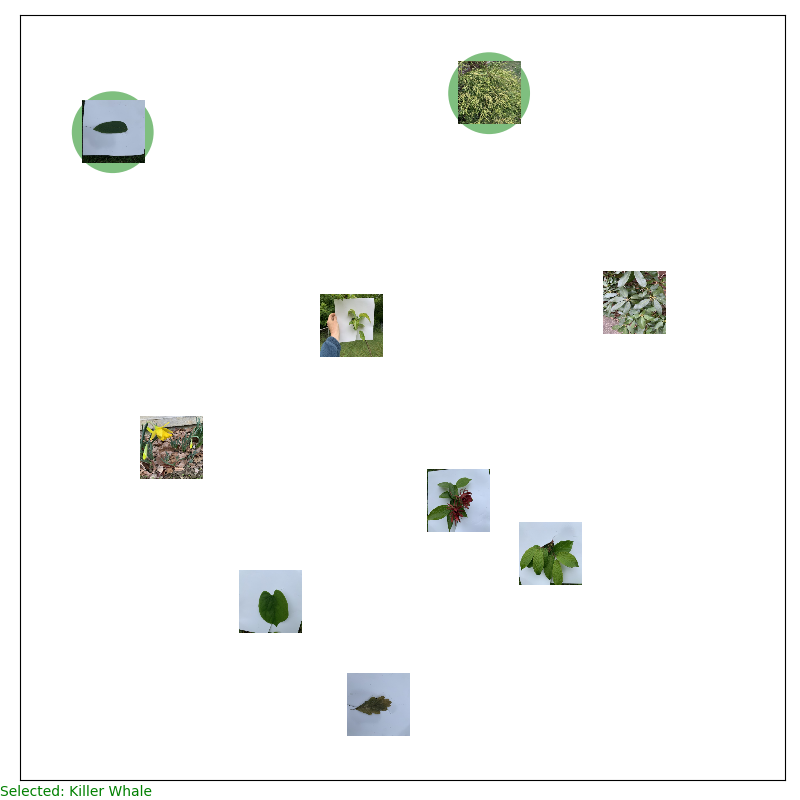

In [32]:
plot_ax = create_plot(df_2D, imgDisplaySize)

In [33]:
size_slider = create_size_slider(imgDisplaySize)
sliders = create_sliders(weights)
size_apply_button = create_size_slider_button(size_slider,plot_ax)

FloatSlider(value=1e-05, continuous_update=False, description='Water', layout=Layout(width='100%'), max=0.9999…

FloatSlider(value=1e-05, continuous_update=False, description='Toughskin', layout=Layout(width='100%'), max=0.…

FloatSlider(value=1e-05, continuous_update=False, description='Timid', layout=Layout(width='100%'), max=0.9999…

FloatSlider(value=1e-05, continuous_update=False, description='Tail', layout=Layout(width='100%'), max=0.9999,…

FloatSlider(value=1e-05, continuous_update=False, description='Strength', layout=Layout(width='100%'), max=0.9…

FloatSlider(value=1e-05, continuous_update=False, description='Stalker', layout=Layout(width='100%'), max=0.99…

FloatSlider(value=1e-05, continuous_update=False, description='Spots', layout=Layout(width='100%'), max=0.9999…

FloatSlider(value=1e-05, continuous_update=False, description='Speed', layout=Layout(width='100%'), max=0.9999…

FloatSlider(value=1e-05, continuous_update=False, description='Smart', layout=Layout(width='100%'), max=0.9999…

FloatSlider(value=1e-05, continuous_update=False, description='Size', layout=Layout(width='100%'), max=0.9999,…

FloatSlider(value=1e-05, continuous_update=False, description='Quadrupedal', layout=Layout(width='100%'), max=…

FloatSlider(value=1e-05, continuous_update=False, description='Paws', layout=Layout(width='100%'), max=0.9999,…

FloatSlider(value=1e-05, continuous_update=False, description='Pads', layout=Layout(width='100%'), max=0.9999,…

FloatSlider(value=1e-05, continuous_update=False, description='Oldworld', layout=Layout(width='100%'), max=0.9…

FloatSlider(value=1e-05, continuous_update=False, description='Nocturnal', layout=Layout(width='100%'), max=0.…

FloatSlider(value=1e-05, continuous_update=False, description='Newworld', layout=Layout(width='100%'), max=0.9…

In [34]:
point_attribute = create_checkbox(size_slider, plot_ax)
inverse_button, copy_button = create_inverse_button(plot_ax, size_slider, sliders)
display(widgets.HBox([inverse_button, copy_button,create_reset_buttons(plot_ax, size_slider, sliders),
                      create_slider_buttons(sliders,size_slider, plot_ax)]))
display(widgets.HBox([size_slider,size_apply_button]))

interactive(children=(Checkbox(value=False, description='Toggle Titles', indent=False, layout=Layout(height='2…

interactive(children=(Checkbox(value=True, description='Toggle Images', indent=False, layout=Layout(height='20…